# Decoding from MARBLE and CEBRA embeddings

In this notebook, we compare MARBLE and CEBRA for decoding.

- decode labels from a MARBLE and CEBRA embedding.
- evaluate and compare the decoding performances for embeddings obtained from different hypotheses.

This notebook is adapted from the demo notebook from CEBRA and is based on what was presented in [Figure 2.d.](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) of Schneider, Lee, Mathis.

**Install note**
- Be sure you have cebra installed to use this notebook

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle

# cebra imports
import cebra
from cebra import CEBRA

# marble imports
import MARBLE
from rat_utils import prepare_marble

2023-11-23 17:46:30.951422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/robert/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/robert/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit 

## Load the data

In [2]:
with open('rat_data.pkl', 'rb') as handle:
    hippocampus_pos = pickle.load(handle)
    
# take only rat achilles
rat = 'achilles'
hippocampus_pos = hippocampus_pos[rat]

**------------------- BEGINNING OF TRAINING SECTION -------------------**

## Train the models

*[This can be skipped if you already saved the models].*


- For a quick CEBRA CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [3]:
max_iterations = 10000 #default is 5000.
output_dimension = 32 #here, we set as a variable for hypothesis testing below.

In [4]:
# defining train and test splits of the data

def split_data(data, test_ratio):

    split_idx = int(data['neural'].shape[0] * (1-test_ratio))
    neural_train = data['neural'][:split_idx]
    neural_test = data['neural'][split_idx:]
    label_train = data['continuous_index'][:split_idx]
    label_test = data['continuous_index'][split_idx:]
    
    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

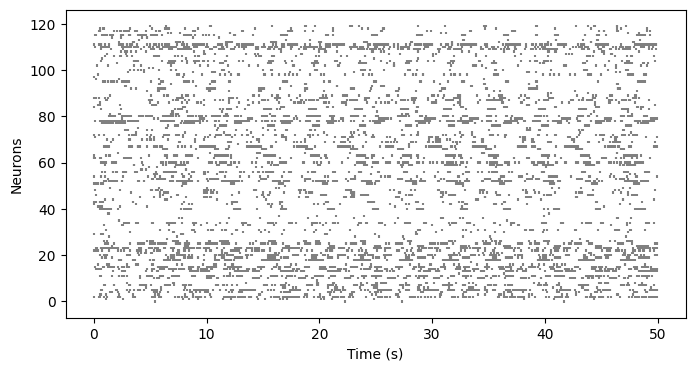

In [5]:
# 40 hz sampling rate (they binned into 25ms epochs

spikes = neural_train[:2000,:].T
spikes = [np.where(spikes[ch,:])[0]/40 for ch in range(120)] 
    
_, ax = plt.subplots(figsize=(8,4))
ax.eventplot(spikes,color='gray')
plt.ylabel('Neurons')
plt.xlabel('Time (s)')
plt.savefig('raster_plot.svg')


### Train CEBRA-Behavior with position, or direction, and/or both variables

In [5]:
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=output_dimension,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [7]:

# Train CEBRA-Behavior models with both position and direction variables.
cebra_time_model.fit(neural_train)
cebra_time_model.save("cebra_time_model.pt")

# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(neural_train, label_train)
cebra_posdir_model.save("cebra_posdir_model.pt")

# Train CEBRA-Behavior models with position or direction variable.
cebra_pos_model.fit(neural_train, label_train[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

cebra_dir_model.fit(neural_train, label_train[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos: -0.8851 neg:  6.3849 total:  5.4997 temperature:  1.0000: 100%|█| 10000/100
pos: -0.8866 neg:  6.4968 total:  5.6102 temperature:  1.0000: 100%|█| 10000/100
pos: -0.8173 neg:  6.4704 total:  5.6531 temperature:  1.0000: 100%|█| 10000/100


### Train MARBLE with only neural data

In [6]:

# build model 
data_train, label_train_marble, pca = prepare_marble(neural_train.T, label_train)

# build model
params = {
    "epochs": 100,  # optimisation epochs
    "order": 1,  # order of derivatives
    "lr": 1,
    "batch_size": 64,
    "hidden_channels": [64], #,64,64],  # number of internal dimensions in MLP
    "out_channels": 32, 
    "inner_product_features": False,
    "vec_norm": False,
    "emb_norm": True, # spherical output embedding
    "diffusion": False,
    "include_positions": True,
  }
model = MARBLE.net(data_train, params=params)

# run training of model
model.run_training(data_train, outdir=f"data/hippocampus_32chan_{rat}")

# evaluate embedding on training data
data_train = model.evaluate(data_train)



[0.25057016 0.1686058  0.08780102 0.07304726 0.0413553  0.03523341
 0.0322533  0.02940006 0.0165167  0.015887  ]
---- Embedding dimension: 10
---- Signal dimension: 10


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 100
order : 1
lr : 1
batch_size : 64
hidden_channels : [64]
out_channels : 32
inner_product_features : False
vec_norm : False
diffusion : False
include_positions : True
momentum : 0.9
frac_sampled_nb : -1
include_self : True
dropout : 0.0
bias : True
batch_norm : None
seed : 0
processes : 1
dim_signal : 10
dim_emb : 10
n_sampled_nb : -1

---- Number of features to pass to the MLP:  120
---- Total number of parameters:  9825

Using device cuda:0

---- Training network ...

Epoch: 0, Training loss: 1.056898, Validation loss: 1.0432, lr: 1.0000 *
Epoch: 1, Training loss: 1.036527, Validation loss: 1.0310, lr: 1.0000 *
Epoch: 2, Training loss: 1.032915, Validation loss: 1.0389, lr: 1.0000
Epoch: 3, Training loss: 1.04213

In [7]:

# build model 
data_test, label_test_marble, _ = prepare_marble(neural_test.T, label_test, pca=pca)

# generate embedding of test data
data_test = model.evaluate(data_test)


[0.25057016 0.1686058  0.08780102 0.07304726 0.0413553  0.03523341
 0.0322533  0.02940006 0.0165167  0.015887  ]
---- Embedding dimension: 10
---- Signal dimension: 10


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


# Compare embeddings after training

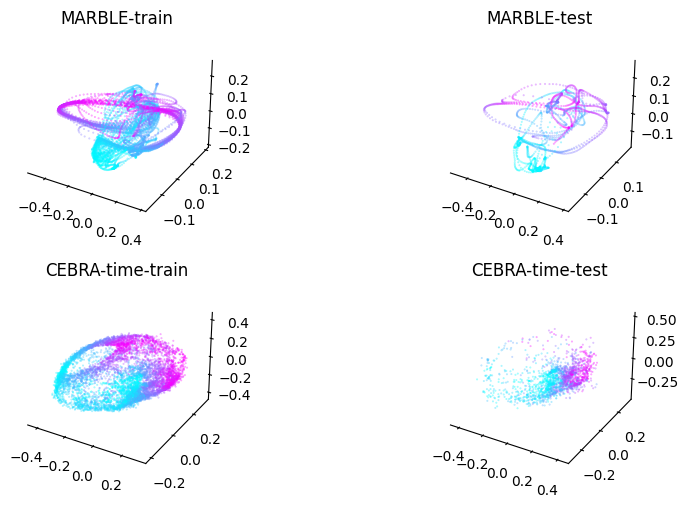

In [10]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,6))


ax1 = plt.subplot(221, projection='3d')
ax=cebra.plot_embedding(ax=ax1, embedding=data_train.emb, embedding_labels=label_train_marble[:,0], markersize=0.2, title='MARBLE-train')

ax2 = plt.subplot(222, projection='3d')
ax=cebra.plot_embedding(ax=ax2, embedding=data_test.emb, embedding_labels=label_test_marble[:,0], markersize=0.2, title='MARBLE-test')

ax3 = plt.subplot(223, projection='3d')
ax=cebra.plot_embedding(ax=ax3, embedding=cebra_time_train, embedding_labels=label_train[:,0], markersize=0.2, title='CEBRA-time-train')

ax4 = plt.subplot(224, projection='3d')
ax=cebra.plot_embedding(ax=ax4, embedding=cebra_time_test, embedding_labels=label_test[:,0], markersize=0.2, title='CEBRA-time-test')

    
plt.show()


**------------------- END OF TRAINING SECTION -------------------**

## Load the models and get the corresponding embeddings

Load the CEBRA models

In [9]:
# We get train set embedding and test set embedding. 

cebra_time_model = cebra.CEBRA.load("cebra_time_model.pt")
cebra_time_train = cebra_time_model.transform(neural_train)
cebra_time_test = cebra_time_model.transform(neural_test)

cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir_train = cebra_posdir_model.transform(neural_train)
cebra_posdir_test = cebra_posdir_model.transform(neural_test)

cebra_pos_model = cebra.CEBRA.load("cebra_pos_model.pt")
cebra_pos_train = cebra_pos_model.transform(neural_train)
cebra_pos_test = cebra_pos_model.transform(neural_test)

cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir_train = cebra_dir_model.transform(neural_train)
cebra_dir_test = cebra_dir_model.transform(neural_test)


cebra_time_all = cebra_time_model.transform(hippocampus_pos['neural'])
cebra_pos_all = cebra_pos_model.transform(hippocampus_pos['neural'])
cebra_dir_all = cebra_dir_model.transform(hippocampus_pos['neural'])
cebra_posdir_all = cebra_posdir_model.transform(hippocampus_pos['neural'])


Load MARBLE models

In [8]:
# load MARBLE

# process data
data_train, label_train_marble, pca = prepare_marble(neural_train.T, label_train)
data_test, label_test_marble, _ = prepare_marble(neural_test.T, label_test, pca=pca)

# load trained model
marble_model = MARBLE.net(data_train, loadpath=f"data/hippocampus_32chan_{rat}")

# generate embedding of test data
data_train = marble_model.evaluate(data_train)
data_test = marble_model.evaluate(data_test)



[0.25057016 0.1686058  0.08780102 0.07304726 0.0413553  0.03523341
 0.0322533  0.02940006 0.01651665 0.01588703]
---- Embedding dimension: 10
---- Signal dimension: 10


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 
[0.25057016 0.1686058  0.08780102 0.07304726 0.0413553  0.03523341
 0.0322533  0.02940006 0.01651665 0.01588703]
---- Embedding dimension: 10
---- Signal dimension: 10


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 10
order : 1
lr : 1
batch_size : 64
hidden_channels : [64, 64, 64]
out_channels : 32
inner_product_features : False
vec_norm : False
diffusion : False
include_positions : True
momentum : 0.9
frac_sampled_nb : -1
include_self : True
dropout : 0.0
bias : True
batch_norm : None
seed : 0
processes : 1
dim_signal : 10
dim_emb : 10
n_sampled_nb : -1

---- Number of features to pass to the MLP:  120
---- Total number of parameters:  18145

Using device cuda:0


### Visualise the embeddings in 3D

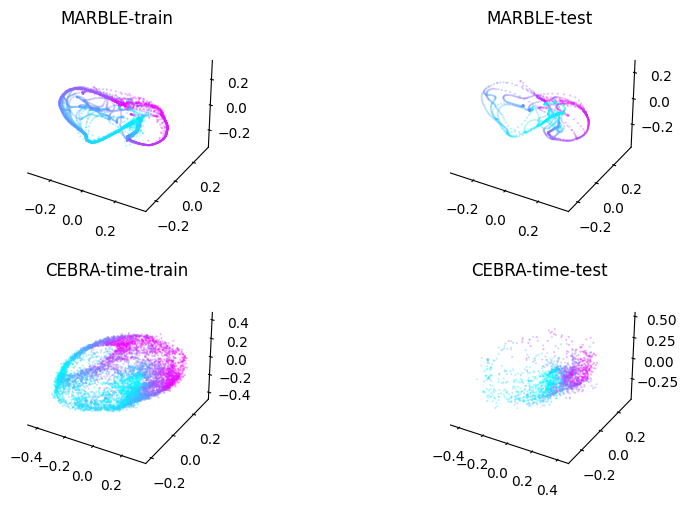

In [21]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,6))


ax1 = plt.subplot(221, projection='3d')
ax=cebra.plot_embedding(ax=ax1, embedding=data_train.emb, embedding_labels=label_train_marble[:,0], markersize=0.2, title='MARBLE-train')

ax2 = plt.subplot(222, projection='3d')
ax=cebra.plot_embedding(ax=ax2, embedding=data_test.emb, embedding_labels=label_test_marble[:,0], markersize=0.2, title='MARBLE-test')

ax3 = plt.subplot(223, projection='3d')
ax=cebra.plot_embedding(ax=ax3, embedding=cebra_time_train, embedding_labels=label_train[:,0], markersize=0.2, title='CEBRA-time-train')

ax4 = plt.subplot(224, projection='3d')
ax=cebra.plot_embedding(ax=ax4, embedding=cebra_time_test, embedding_labels=label_test[:,0], markersize=0.2, title='CEBRA-time-test')


plt.savefig('marble_cebra_embeddings_3D_32output.svg')  
plt.savefig('marble_cebra_embeddings_3D_32output.png')  
plt.show()

## Decode the labels from the embeddings
We evaluate decoding performance of the different hypothesis models.

In [11]:
from rat_utils import find_sequences, decoding_pos_dir
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator

### Decode the position and direction from the trained hypothesis models

In [12]:
cebra_time_decode = decoding_pos_dir(cebra_time_train, cebra_time_test, label_train, label_test)
cebra_posdir_decode = decoding_pos_dir(cebra_posdir_train, cebra_posdir_test, label_train, label_test)
cebra_pos_decode = decoding_pos_dir(cebra_pos_train, cebra_pos_test, label_train, label_test)
cebra_dir_decode = decoding_pos_dir(cebra_dir_train, cebra_dir_test, label_train, label_test)
marble_decode = decoding_pos_dir(data_train.emb, data_test.emb, label_train_marble, label_test_marble)


### Visualize the decoding results and loss - decoding performance

/home/robert/anaconda3/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

c-pos vs. marble: Wilcoxon test (paired samples), P_val:1.391e-15 Stat=7.934e+05
c-pos+dir vs. marble: Wilcoxon test (paired samples), P_val:1.210e-18 Stat=7.720e+05
c-time vs. marble: Wilcoxon test (paired samples), P_val:4.674e-103 Stat=4.431e+05


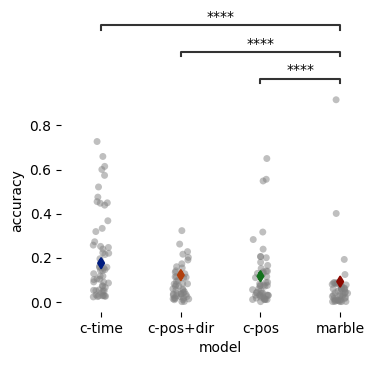

In [21]:
results = [cebra_time_decode[4][:-1], cebra_posdir_decode[4][:-1],  cebra_pos_decode[4][:-1], #cebra_dir_decode[5],
        marble_decode[4]]

results = pd.DataFrame(data=np.vstack(results).T,columns=['c-time','c-pos+dir', 'c-pos', 'marble'])
results = results.melt()
results.columns = ['model','accuracy']

f, ax = plt.subplots(figsize=(4,4))
sns.despine(bottom=True, left=True)


random_sampling = np.random.randint(low=0, high=results.shape[0], size=(200,))

sns.stripplot(
    data=results.iloc[random_sampling,:], x="model", y="accuracy", order=['c-time','c-pos+dir', 'c-pos', 'marble'], 
    dodge=True, alpha=.5, zorder=1, color='gray',
)

sns.pointplot(
    data=results, x="model", y="accuracy",
    join=False, dodge=.8 - .8 / 3, palette="dark",
    markers="d", scale=.75, errorbar=None
)

pairs=[("c-time", "marble"),
      ("c-pos+dir", "marble"),
      ("c-pos", "marble"),
      ]

annotator = Annotator(ax, pairs, data=results, x="model", y="accuracy",)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.tight_layout()
plt.savefig('decoding_accuracy_rat_32output_violin.svg')  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


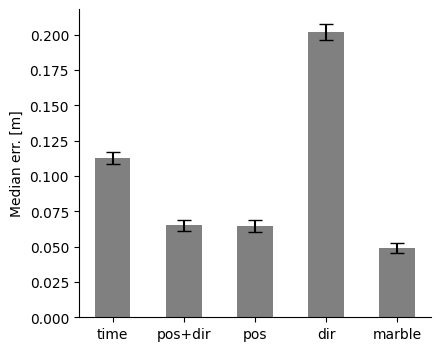

In [16]:
from scipy.stats import sem

fig = plt.figure(figsize=(10,4))

ax1= plt.subplot(121)
ax1.bar(np.arange(5), 
        [cebra_time_decode[1], cebra_posdir_decode[1],  cebra_pos_decode[1], cebra_dir_decode[1],
        marble_decode[1]], 
        width = 0.5, color = 'gray')

ax1.errorbar(np.arange(5),  
             [cebra_time_decode[1], cebra_posdir_decode[1],  cebra_pos_decode[1], cebra_dir_decode[1],
             marble_decode[1]],
             yerr=[sem(cebra_time_decode[4]), sem(cebra_posdir_decode[4]),  
                   sem(cebra_pos_decode[4]), sem(cebra_dir_decode[4]),
                   sem(marble_decode[4])], 
             fmt='none', ecolor='black', capsize=5)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xticks(np.arange(5))
ax1.set_xticklabels(['time','pos+dir', 'pos', 'dir','marble'])
ax1.set_ylabel('Median err. [m]')


plt.legend(bbox_to_anchor=(1,1), frameon = False )
plt.savefig('decoding_accuracy_rat_32output_standarderror.svg')  
plt.show()

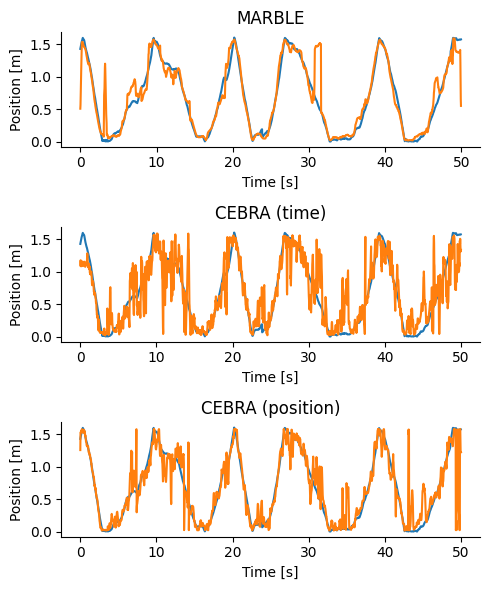

In [22]:
fig = plt.figure(figsize=(5,6))

t = label_test_marble[:,0].shape[0]

ax1= plt.subplot(311)
ax1.plot(np.arange(t)/40, label_test_marble[:,0])
ax1.plot(np.arange(t)/40, marble_decode[3][:,0])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Position [m]')
ax1.set_title('MARBLE')

ax2= plt.subplot(312)
ax2.plot(np.arange(t)/40, label_test_marble[:,0])
ax2.plot(np.arange(t+1)/40, cebra_time_decode[3][:,0])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Position [m]')
ax2.set_title('CEBRA (time)')

ax3 = plt.subplot(313)
ax3.plot(np.arange(t)/40, label_test_marble[:,0])
ax3.plot(np.arange(t+1)/40, cebra_pos_decode[3][:,0])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Position [m]')
ax3.set_title('CEBRA (position)')

plt.savefig('decoding_vs_groundtruth_32output.svg')  


plt.tight_layout()
